### Imports

In [1]:
%pip install pysr kagglehub[pandas-datasets]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 11.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np
from pysr import PySRRegressor
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler

2025-11-11 07:36:54.830336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762846615.023444      85 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762846615.077343      85 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/usr/local/lib/python3.11/dist-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia 1.10.3 - 1.11
[juliapkg] Using Julia 1.11.5 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Writing Project.toml:
           | [deps]
           | SymbolicRegression = "8254be44-1295-4e6a-a16d-46603ac705cb"
           | Serialization = "9e88b42a-f829-5b0c-bbe9-9e923198166b"
           | PythonCall = "6099a3de-0909-46bc-b1f4-468b9a2dfc0d"
           | OpenSSL_jll = "458c3c95-2e84-50aa-8efc-19380b2a3a95"
           | 
           | [compat]
           | SymbolicRegression = "~1.11"
           | Serialization = "^1"
           | PythonCall = "=0.9.26"
           | OpenSSL_jll = "~3.0"
[juliapkg] Installing packages:
           | impo

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed IrrationalConstants ────── v0.2.6
   Installed ScientificTypesBase ────── v3.0.0
   Installed Adapt ──────────────────── v4.4.0
   Installed MicroMamba ─────────────── v0.1.14
   Installed Tricks ─────────────────── v0.1.13
   Installed MLJModelInterface ──────── v1.11.1
   Installed DynamicExpressions ─────── v1.10.3
   Installed PythonCall ─────────────── v0.9.26
   Installed JSON3 ──────────────────── v1.14.3
   Installed PositiveFactorizations ─── v0.2.4
   Installed ADTypes ────────────────── v1.18.0
   Installed Preferences ────────────── v1.5.0
   Installed SpecialFunctions ───────── v2.6.1
   Installed Optim ──────────────────── v1.13.2
   Installed OpenSSL_jll ────────────── v3.0.16+0
   Installed StatisticalTraits ──────── v3.5.0
   Installed Pidfile ────────────────── v1.3.0
   Installed micromamba_jll ─────────── v1.5.12+0
   Installed StaticArraysCore ───────── v1.4.4


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


### Autoencoder

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(input_dim * 0.65)),
            nn.SiLU(),
            nn.Linear(int(input_dim * 0.65), int(input_dim * 0.4)),
            nn.SiLU(),
            nn.Linear(int(input_dim * 0.4), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, int(input_dim * 0.4)),
            nn.SiLU(),
            nn.Linear(int(input_dim * 0.4), int(input_dim * 0.65)),
            nn.SiLU(),
            nn.Linear(int(input_dim * 0.65), input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

def train_autoencoder(model, train_loader, epochs=64):
    optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=6e-3)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch, in train_loader:
            optimizer.zero_grad()
            recon, _ = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")

    return model

### Tabular

In [4]:
torch.manual_seed(24)
np.random.seed(24)

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS, "uciml/forest-cover-type-dataset", "covtype.csv")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

X_tabular = df.drop('Cover_Type', axis=1).values
y_tabular = df['Cover_Type'].values
feature_names = df.drop('Cover_Type', axis=1).columns.tolist()

sample_size = 4096
sample_idx = np.random.choice(len(X_tabular), sample_size, replace=False)
X_tabular = X_tabular[sample_idx]
y_tabular = y_tabular[sample_idx]

print(f"Sampled data shape: {X_tabular.shape}")

Dataset shape: (581012, 55)
Columns: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']
Sampled data shape: (4096, 54)


In [5]:
scaler = StandardScaler()
X_tabular_normalized = scaler.fit_transform(X_tabular)
X_tabular_tensor = torch.FloatTensor(X_tabular_normalized)

train_size_tab = int(0.8 * len(X_tabular_tensor))
train_data_tab = X_tabular_tensor[:train_size_tab]
test_data_tab = X_tabular_tensor[train_size_tab:]

train_loader_tab = DataLoader(TensorDataset(train_data_tab), batch_size=32, shuffle=True)
test_loader_tab = DataLoader(TensorDataset(test_data_tab), batch_size=32)

In [6]:
input_dim_tab = X_tabular_tensor.shape[1]
latent_dim_tab = 32

print(f"\nTraining autoencoder ({input_dim_tab} -> {latent_dim_tab} -> {input_dim_tab})...")
autoencoder_tab = Autoencoder(input_dim_tab, latent_dim_tab)
autoencoder_tab = train_autoencoder(autoencoder_tab, train_loader_tab, epochs=45)

print("Extracting latent representations...")
autoencoder_tab.eval()
with torch.no_grad():
    all_inputs_tab = train_data_tab
    all_recons_tab, all_latents_tab = autoencoder_tab(all_inputs_tab)

X_input_tab = all_inputs_tab.numpy()
Z_latent_tab = all_latents_tab.numpy()

print(f"Input shape: {X_input_tab.shape}, Latent shape: {Z_latent_tab.shape}")


Training autoencoder (54 -> 32 -> 54)...
Epoch 10/45, Loss: 0.249864
Epoch 20/45, Loss: 0.199040
Epoch 30/45, Loss: 0.172095
Epoch 40/45, Loss: 0.164361

Extracting latent representations...
Input shape: (3276, 54), Latent shape: (3276, 32)


In [7]:
latent_formulas_tab = {}
input_importance_tab = np.zeros(input_dim_tab)

print("Finding symbolic formulas for latent dimensions (tabular)...")
for i in tqdm(range(min(8, latent_dim_tab))):
    model_sr = PySRRegressor(
        niterations=80,
        populations=45,
        binary_operators=["+", "-", "*", "/", "^", "max", "min", "mod"],
        unary_operators=["neg", "square", "cube", "cbrt", "sqrt", "abs", "sign", "inv", "exp", "log", "log10", "log2", "log1p", "sin", "cos", "tan", "asin", "acos", "atan", "sinh", "cosh", "tanh", "asinh", "acosh", "atanh", "relu", "sinc", "floor", "ceil"],
        parsimony=0.1,
        verbosity=0,
        model_selection="best",
    )

    sample_idx = np.random.choice(len(X_input_tab), min(1024, len(X_input_tab)), replace=False)
    X_sample = X_input_tab[sample_idx]
    z_sample = Z_latent_tab[sample_idx, i]

    model_sr.fit(X_sample, z_sample)

    best_formula = str(model_sr.sympy())
    latent_formulas_tab[i] = best_formula

    for j in range(input_dim_tab):
        if f'x{j}' in best_formula:
            input_importance_tab[j] += 1


Finding symbolic formulas for latent dimensions (tabular)...


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
┌ Warning: You have passed over 15 unary operators. To prevent long compilation times, some optimizations will be disabled. If this presents an issue, please open an issue on https://github.com/SymbolicML/DynamicExpressions.jl
└ @ DynamicExpressions.OperatorEnumConstructionModule ~/.julia/packages/DynamicExpressions/cYbpm/src/OperatorEnumConstruction.jl:446
/usr/local/lib/python3.11/dist

In [8]:
print("--- Discovered Latent Formulas ---")
for i in range(min(5, len(latent_formulas_tab))):
    formula = latent_formulas_tab[i]
    if len(formula) > 100:
        formula = formula[:97] + "..."
    print(f"z_{i} = {formula}")


--- Discovered Latent Formulas (Tabular) ---
z_0 = -sinh(atan(x38))**3 + log2(Piecewise((Piecewise((sinc(x18), ITE(x35 > x14 + x36 + x47**3 + x52, s...
z_1 = asinh(x45 - (x43 - (-x25 - x29 - x35 + x51)) - (Piecewise((0.0, x24 + (x22 + x22 + x31 + x48)**3 ...
z_2 = (x0 + x10 + x29 + x43 + x47 + x52 - Piecewise((x18, x16 < x18), (x16, True)))/1.8505275
z_3 = -asinh(-x10 + x26 + x45 + floor((x14 - (x31 + x48) + asinh(x15 + x44 + x50))**3))
z_4 = atan(Piecewise((x33, ITE(x37 > x52, x33 > Abs(x37 + 0.19862415)**(1/3)*sign(x37 + 0.19862415), x3...


In [9]:
threshold = 0
discarded_dims_tab = np.sort(np.where(input_importance_tab == threshold)[0], kind="stable")
important_dims_tab = np.where(input_importance_tab > 2)[0][np.argsort(-input_importance_tab[input_importance_tab > 2], kind="stable")]

print("\n--- Input Feature Usage Analysis (Tabular) ---")
print(f"Highly important features (appear in >2 latents): {len(important_dims_tab)}")
print("Examples:")
for idx in important_dims_tab[:10]:
    print(f"  Feature {idx} ({feature_names[idx]}): used {int(input_importance_tab[idx])} times")

print(f"\nPotentially redundant features (never appear): {len(discarded_dims_tab)}")
print("Examples:")
for idx in discarded_dims_tab[:10]:
    print(f"  Feature {idx} ({feature_names[idx]})")


--- Input Feature Usage Analysis (Tabular) ---
Highly important features (appear in >2 latents): 12
Examples:
  Feature 4 (Vertical_Distance_To_Hydrology): used 8 times
  Feature 3 (Horizontal_Distance_To_Hydrology): used 7 times
  Feature 2 (Slope): used 6 times
  Feature 5 (Horizontal_Distance_To_Roadways): used 6 times
  Feature 1 (Aspect): used 5 times
  Feature 43 (Soil_Type30): used 5 times
  Feature 31 (Soil_Type18): used 4 times
  Feature 18 (Soil_Type5): used 3 times
  Feature 24 (Soil_Type11): used 3 times
  Feature 44 (Soil_Type31): used 3 times

Potentially redundant features (never appear): 17
Examples:
  Feature 6 (Hillshade_9am)
  Feature 7 (Hillshade_Noon)
  Feature 8 (Hillshade_3pm)
  Feature 9 (Horizontal_Distance_To_Fire_Points)
  Feature 11 (Wilderness_Area2)
  Feature 12 (Wilderness_Area3)
  Feature 13 (Wilderness_Area4)
  Feature 17 (Soil_Type4)
  Feature 20 (Soil_Type7)
  Feature 21 (Soil_Type8)


In [10]:
latent_dims_to_test_tab = [4, 8, 16, 24, 32]
reconstruction_errors_tab = {}

print("Training autoencoders with different latent dimensions (tabular)...")
for ld in latent_dims_to_test_tab:
    print(f"\nLatent dim = {ld}")
    ae = Autoencoder(input_dim_tab, ld)
    ae = train_autoencoder(ae, train_loader_tab, epochs=60)

    ae.eval()
    with torch.no_grad():
        recon, _ = ae(test_data_tab)
        errors = ((recon - test_data_tab) ** 2).mean(dim=0).numpy()

    reconstruction_errors_tab[ld] = errors


Training autoencoders with different latent dimensions (tabular)...

Latent dim = 4
Epoch 10/60, Loss: 0.337637
Epoch 20/60, Loss: 0.243143
Epoch 30/60, Loss: 0.211936
Epoch 40/60, Loss: 0.190031
Epoch 50/60, Loss: 0.188685
Epoch 60/60, Loss: 0.188826

Latent dim = 8
Epoch 10/60, Loss: 0.262438
Epoch 20/60, Loss: 0.195942
Epoch 30/60, Loss: 0.180400
Epoch 40/60, Loss: 0.173591
Epoch 50/60, Loss: 0.171267
Epoch 60/60, Loss: 0.169619

Latent dim = 16
Epoch 10/60, Loss: 0.249300
Epoch 20/60, Loss: 0.181386
Epoch 30/60, Loss: 0.168125
Epoch 40/60, Loss: 0.162776
Epoch 50/60, Loss: 0.159353
Epoch 60/60, Loss: 0.161342

Latent dim = 24
Epoch 10/60, Loss: 0.249412
Epoch 20/60, Loss: 0.194354
Epoch 30/60, Loss: 0.180050
Epoch 40/60, Loss: 0.171557
Epoch 50/60, Loss: 0.171204
Epoch 60/60, Loss: 0.162991

Latent dim = 32
Epoch 10/60, Loss: 0.242815
Epoch 20/60, Loss: 0.189092
Epoch 30/60, Loss: 0.173475
Epoch 40/60, Loss: 0.167849
Epoch 50/60, Loss: 0.163921
Epoch 60/60, Loss: 0.159323


In [11]:
error_data_tab = []
for feature_j in range(input_dim_tab):
    for ld in latent_dims_to_test_tab:
        error_data_tab.append({
            'feature_id': feature_j,
            'feature_name': feature_names[feature_j],
            'latent_dim': ld,
            'reconstruction_error': reconstruction_errors_tab[ld][feature_j]
        })

df_errors_tab = pd.DataFrame(error_data_tab)
print("--- Reconstruction Error Analysis (Tabular) ---")
print(f"Total data points: {len(df_errors_tab)}")


--- Reconstruction Error Analysis (Tabular) ---
Total data points: 270


In [12]:
feature_properties_tab = pd.DataFrame({
    'feature_id': range(input_dim_tab),
    'feature_name': feature_names,
    'mean': X_input_tab.mean(axis=0),
    'std': X_input_tab.std(axis=0),
    'importance': input_importance_tab
})

df_merged_tab = df_errors_tab.merge(feature_properties_tab, on='feature_id')

print("Finding symbolic law for reconstruction error (tabular)...")
X_recon_sr_tab = df_merged_tab[['latent_dim', 'mean', 'std', 'importance']].values
y_recon_sr_tab = df_merged_tab['reconstruction_error'].values

model_recon_sr_tab = PySRRegressor(
    niterations=70,
    populations=35,
    binary_operators=["+", "-", "*", "/", "^", "max", "min", "mod"],
    unary_operators=["neg", "square", "cube", "cbrt", "sqrt", "abs", "sign", "inv", "exp", "log", "log10", "log2", "log1p", "sin", "cos", "tan", "asin", "acos", "atan", "sinh", "cosh", "tanh", "asinh", "acosh", "atanh", "relu", "sinc", "floor", "ceil"],
    parsimony=0.01,
    verbosity=0,
    model_selection="best",
)

sample_idx = np.random.choice(len(X_recon_sr_tab), min(2048, len(X_recon_sr_tab)), replace=False)
model_recon_sr_tab.fit(X_recon_sr_tab[sample_idx], y_recon_sr_tab[sample_idx])


Finding symbolic law for reconstruction error (tabular)...


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
┌ Warning: You have passed over 15 unary operators. To prevent long compilation times, some optimizations will be disabled. If this presents an issue, please open an issue on https://github.com/SymbolicML/DynamicExpressions.jl
└ @ DynamicExpressions.OperatorEnumConstructionModule ~/.julia/packages/DynamicExpressions/cYbpm/src/OperatorEnumConstruction.jl:446


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          0.2512929   
	1         1.958588e-01                                mod(x2, 0.91975445)   
	2         3.249042e-02                             tan(mod(x2, 0.920561))   
	3         5.610728e-01                  square(cube(mod(x2, -1.8182235)))   
	4         2.952826e-01          square(square(mod(cube(x2), -1.6364534)))   
	5         3.875914e-02      square(asinh(cube(mod(cube(x2), -1.734739))))   
	6         2.695123e-02  asinh(square(mod(cube(x2), -1.7405028)) ^ 3.39...   
	7         3.273338e-07  asinh(square(square(mod(cube(x2), -1.7405292))...   
	8         1.627218e-01  max(floor(sinc(cube(x2)) * (x2 / 0.18187542)),...   
	9         1.045272e-01  (mod(x2, 0.94016373) * sinc(x3 + cube(x2))) / ...   
	10        1.614540e-01  mod(x2, 0.9177812) * ((sinc(max(x3, x2)) / 0.0...   
	11  >>>>  1.663587e-01  max((mod(x2, 0.9347523) * sinc(x3 + cube(x2)))...   
	12        4.212850e-03  max(sinc(x3 + cube(x2)) * (mod(x2, 0.9347523) ...   
	13        4.856160e-03  max(sinc(x3 + cube(x2)) * (mod(x2, 0.9347523) ...   
	14        1.116864e-02  max(x3 * 0.03706852, ((mod(x2, 0.9347523) / 0....   
	15        5.206394e-02  max((mod(x2, 0.9347523) / 0.17197838) * sinc(x...   
	16        8.460651e-03  max(max(0.929301, x3) * 0.03706852, (sinc(cube...   
	17        1.745430e-03  max(max(x2, x3) * 0.03706852, ((sinc(x3 + cube...   
	18        3.004614e-02  max(max(cosh(x2), x3) * 0.03706852, (sinc(x3 +...   
	19        4.543608e-03  abs((-0.24753807 * (x2 - sqrt(x3))) - floor(si...   
	20        3.108536e-02  max(sinc(cube(x2) + x3) * (mod(x2, 0.9347523) ...   
	21        1.929646e-02  max(sinc(cube(x2) + x3) * (mod(x2, 0.93925935)...   
	
	        loss  complexity  
	0   0.293514           1  
	1   0.198385           3  
	2   0.192043           4  
	3   0.109579           5  
	4   0.081562           6  
	5   0.078461           7  
	6   0.076375           8  
	7   0.076375           9  
	8   0.064905          10  
	9   0.058463          11  
	10  0.049747          12  
	11  0.042123          13  
	12  0.041769          15  
	13  0.041567          16  
	14  0.041105          17  
	15  0.039020          18  
	16  0.038691          19  
	17  0.038624          20  
	18  0.037481          21  
	19  0.036806          25  
	20  0.034587          27  
	21  0.033926          28  
]

In [13]:
print("--- Discovered Reconstruction Law (Tabular) ---")
print(f"reconstruction_error = {model_recon_sr_tab.sympy()}")
print("Where:")
print("  x0 = latent_dim")
print("  x1 = feature_mean")
print("  x2 = feature_std")
print("  x3 = feature_importance")

best_reconstructed_tab = []
worst_reconstructed_tab = []

for feature_j in range(input_dim_tab):
    avg_error = df_errors_tab[df_errors_tab['feature_id'] == feature_j]['reconstruction_error'].mean()
    if avg_error < df_errors_tab['reconstruction_error'].quantile(0.1):
        best_reconstructed_tab.append((feature_j, avg_error))
    elif avg_error > df_errors_tab['reconstruction_error'].quantile(0.9):
        worst_reconstructed_tab.append((feature_j, avg_error))

print("\n--- Best Reconstructed Features (Tabular, top 10) ---")
for feat, err in sorted(best_reconstructed_tab, key=lambda x: x[1])[:10]:
    print(f"Feature {feat} ({feature_names[feat]}): error = {err:.6f}, importance = {input_importance_tab[feat]}")

print("\n--- Worst Reconstructed Features (Tabular, top 10) ---")
for feat, err in sorted(worst_reconstructed_tab, key=lambda x: x[1], reverse=True)[:10]:
    print(f"Feature {feat} ({feature_names[feat]}): error = {err:.6f}, importance = {input_importance_tab[feat]}")


--- Discovered Reconstruction Law (Tabular) ---
reconstruction_error = Piecewise((0.13303071, (Mod(1.0*x2, 0.9347523))*sinc(x2**3 + x3)/0.17197838 < 0.13303071), ((Mod(1.0*x2, 0.9347523))*sinc(x2**3 + x3)/0.17197838, True))

Where:
  x0 = latent_dim
  x1 = feature_mean
  x2 = feature_std
  x3 = feature_importance

--- Best Reconstructed Features (Tabular, top 10) ---
Feature 28 (Soil_Type15): error = 0.000108, importance = 0.0
Feature 20 (Soil_Type7): error = 0.000330, importance = 0.0
Feature 31 (Soil_Type18): error = 0.017539, importance = 4.0

--- Worst Reconstructed Features (Tabular, top 10) ---
Feature 27 (Soil_Type14): error = 3.309337, importance = 0.0
Feature 21 (Soil_Type8): error = 1.563003, importance = 0.0
Feature 49 (Soil_Type36): error = 1.515511, importance = 0.0
Feature 47 (Soil_Type34): error = 0.746307, importance = 2.0
Feature 9 (Horizontal_Distance_To_Fire_Points): error = 0.632928, importance = 0.0
Feature 5 (Horizontal_Distance_To_Roadways): error = 0.547092, im

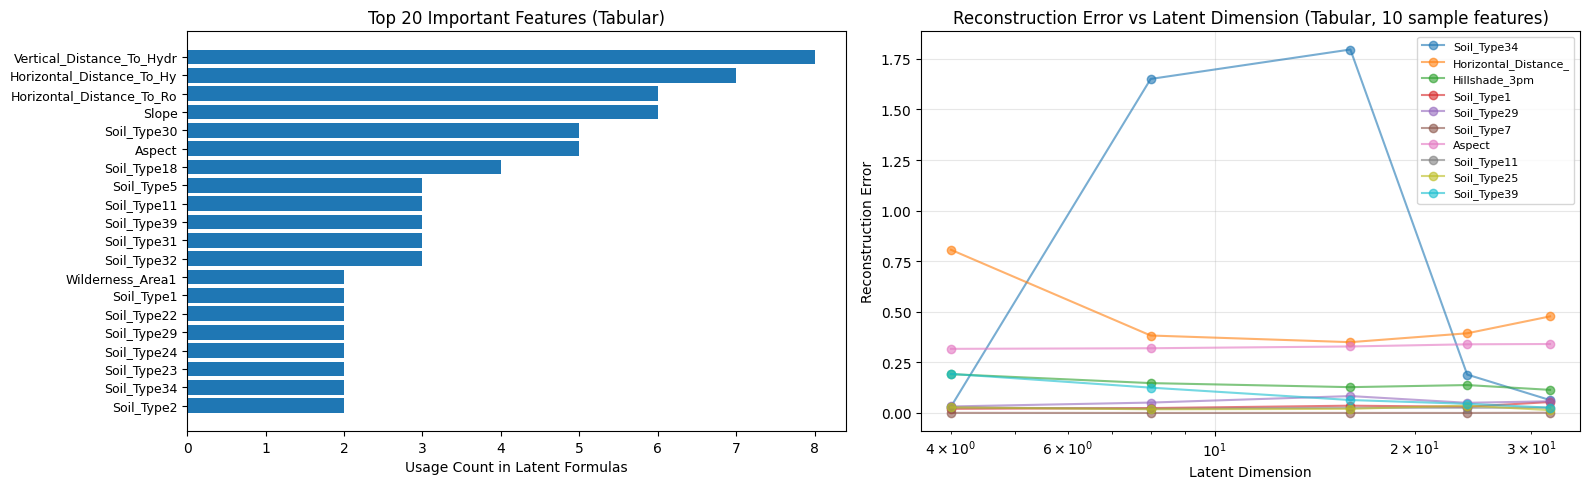

In [14]:
fig_tab, axes_tab = plt.subplots(1, 2, figsize=(16, 5))

top_n = 20
top_indices = np.argsort(input_importance_tab)[-top_n:][::-1]
top_names = [feature_names[i][:25] for i in top_indices]
axes_tab[0].barh(range(top_n), input_importance_tab[top_indices])
axes_tab[0].set_yticks(range(top_n))
axes_tab[0].set_yticklabels(top_names, fontsize=9)
axes_tab[0].set_xlabel('Usage Count in Latent Formulas')
axes_tab[0].set_title('Top 20 Important Features (Tabular)')
axes_tab[0].invert_yaxis()

sample_features_tab = np.random.choice(input_dim_tab, 10, replace=False)
for feat in sample_features_tab:
    errors = [reconstruction_errors_tab[ld][feat] for ld in latent_dims_to_test_tab]
    label = feature_names[feat][:20] if len(feature_names[feat]) > 20 else feature_names[feat]
    axes_tab[1].plot(latent_dims_to_test_tab, errors, marker='o', alpha=0.6, label=label)

axes_tab[1].set_xlabel('Latent Dimension')
axes_tab[1].set_ylabel('Reconstruction Error')
axes_tab[1].set_title('Reconstruction Error vs Latent Dimension (Tabular, 10 sample features)')
axes_tab[1].set_xscale('log')
axes_tab[1].grid(True, alpha=0.3)
axes_tab[1].legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

### Text

In [15]:
torch.manual_seed(24)
np.random.seed(24)

dataset = load_dataset("imdb", split="train[:4096]")
texts = dataset['text']

model_st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

embeddings = model_st.encode(texts, show_progress_bar=True, batch_size=32)
embeddings = torch.FloatTensor(embeddings)

print(f"Embeddings shape: {embeddings.shape}")

embeddings_mean = embeddings.mean(dim=0)
embeddings_std = embeddings.std(dim=0)
embeddings_normalized = (embeddings - embeddings_mean) / (embeddings_std + 1e-8)

train_size_text = int(0.8 * len(embeddings_normalized))
train_data_text = embeddings_normalized[:train_size_text]
test_data_text = embeddings_normalized[train_size_text:]

train_loader = DataLoader(TensorDataset(train_data_text), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data_text), batch_size=32)

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/128 [00:00<?, ?it/s]

Embeddings shape: torch.Size([4096, 384])


In [16]:
input_dim = embeddings_normalized.shape[1]
latent_dim = 32

print(f"\nTraining autoencoder ({input_dim} -> {latent_dim} -> {input_dim})...")
autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder = train_autoencoder(autoencoder, train_loader, 80)

print("Extracting latent representations...")
autoencoder.eval()
with torch.no_grad():
    all_inputs = train_data_text
    all_recons, all_latents = autoencoder(all_inputs)

X_input = all_inputs.numpy()
Z_latent = all_latents.numpy()
X_recon = all_recons.numpy()

print(f"Input shape: {X_input.shape}, Latent shape: {Z_latent.shape}")


Training autoencoder (384 -> 32 -> 384)...
Epoch 10/80, Loss: 0.516467
Epoch 20/80, Loss: 0.455663
Epoch 30/80, Loss: 0.428283
Epoch 40/80, Loss: 0.411386
Epoch 50/80, Loss: 0.402106
Epoch 60/80, Loss: 0.392747
Epoch 70/80, Loss: 0.388087
Epoch 80/80, Loss: 0.382835

Extracting latent representations...
Input shape: (3276, 384), Latent shape: (3276, 32)


In [17]:
latent_formulas = {}
input_importance = np.zeros(input_dim)

print("Finding symbolic formulas for latent dimensions...")
for i in tqdm(range(min(8, latent_dim))):
    model_sr = PySRRegressor(
        niterations=64,
        populations=45,
        binary_operators=["+", "-", "*", "/", "^", "max", "min", "mod"],
        unary_operators=["neg", "square", "cube", "cbrt", "sqrt", "abs", "sign", "inv", "exp", "log", "log10", "log2", "log1p", "sin", "cos", "tan", "asin", "acos", "atan", "sinh", "cosh", "tanh", "asinh", "acosh", "atanh", "relu", "sinc", "floor", "ceil"],
        parsimony=0.01,
        verbosity=0,
        model_selection="best",
    )

    sample_idx = np.random.choice(len(X_input), min(1024, len(X_input)), replace=False)
    X_sample = X_input[sample_idx]
    z_sample = Z_latent[sample_idx, i]

    model_sr.fit(X_sample, z_sample)

    best_formula = str(model_sr.sympy())
    latent_formulas[i] = best_formula

    for j in range(input_dim):
        if f'x{j}' in best_formula:
            input_importance[j] += 1


Finding symbolic formulas for latent dimensions...


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
┌ Warning: You have passed over 15 unary operators. To prevent long compilation times, some optimizations will be disabled. If this presents an issue, please open an issue on https://github.com/SymbolicML/DynamicExpressions.jl
└ @ DynamicExpressions.OperatorEnumConstructionModule ~/.julia/packages/DynamicExpressions/cYbpm/src/OperatorEnumConstruction.jl:446
/usr/local/lib/python3.11/dist

In [18]:
print("--- Discovered Latent Formulas (sample) ---")
for i in range(min(5, len(latent_formulas))):
    formula = latent_formulas[i]
    if len(formula) > 100:
        formula = formula[:97] + "..."
    print(f"z_{i} = {formula}")


--- Discovered Latent Formulas (sample) ---
z_0 = asinh(x142 - x262)
z_1 = asinh(x335 + x343 - x352)
z_2 = x110 + x6
z_3 = Piecewise((x233 + x7, x136 + x25 > x233 + x7), (x136 + x25, True))
z_4 = Piecewise((x225, x225 < x172 - x204 - x61), (x172 - x204 - x61, True))


In [19]:
threshold = 0
discarded_dims = np.sort(np.where(input_importance == threshold)[0], kind="stable")
important_dims = np.where(input_importance > 2)[0][np.argsort(-input_importance[input_importance > 2], kind="stable")]

print("\n--- Input Dimension Usage Analysis ---")
print(f"Highly important dimensions (appear in >2 latents): {len(important_dims)}")
print(f"Examples: {important_dims[:10].tolist()}")
print(f"\nPotentially redundant dimensions (never appear): {len(discarded_dims)}")
print(f"Examples: {discarded_dims[:10].tolist()}")


--- Input Dimension Usage Analysis ---
Highly important dimensions (appear in >2 latents): 2
Examples: [1, 2]

Potentially redundant dimensions (never appear): 343
Examples: [0, 4, 8, 9, 10, 15, 16, 18, 19, 21]


In [20]:
latent_dims_to_test = [4, 8, 16, 32, 64]
reconstruction_errors = {}

print("Training autoencoders with different latent dimensions...")
for ld in latent_dims_to_test:
    print(f"\nLatent dim = {ld}")
    ae = Autoencoder(input_dim, ld)
    ae = train_autoencoder(ae, train_loader, 80)

    ae.eval()
    with torch.no_grad():
        recon, _ = ae(test_data_text)
        errors = ((recon - test_data_text) ** 2).mean(dim=0).numpy()

    reconstruction_errors[ld] = errors

error_data = []
for feature_j in range(input_dim):
    for ld in latent_dims_to_test:
        error_data.append({
            'feature_id': feature_j,
            'latent_dim': ld,
            'reconstruction_error': reconstruction_errors[ld][feature_j]
        })

df_errors = pd.DataFrame(error_data)

print("--- Reconstruction Error Analysis ---")
print(f"Total data points: {len(df_errors)}")


Training autoencoders with different latent dimensions...

Latent dim = 4
Epoch 10/80, Loss: 0.802996
Epoch 20/80, Loss: 0.763843
Epoch 30/80, Loss: 0.740035
Epoch 40/80, Loss: 0.722178
Epoch 50/80, Loss: 0.707007
Epoch 60/80, Loss: 0.698494
Epoch 70/80, Loss: 0.689712
Epoch 80/80, Loss: 0.681732

Latent dim = 8
Epoch 10/80, Loss: 0.699921
Epoch 20/80, Loss: 0.644044
Epoch 30/80, Loss: 0.612055
Epoch 40/80, Loss: 0.590430
Epoch 50/80, Loss: 0.576454
Epoch 60/80, Loss: 0.565895
Epoch 70/80, Loss: 0.554483
Epoch 80/80, Loss: 0.547597

Latent dim = 16
Epoch 10/80, Loss: 0.595827
Epoch 20/80, Loss: 0.540223
Epoch 30/80, Loss: 0.509192
Epoch 40/80, Loss: 0.491331
Epoch 50/80, Loss: 0.476363
Epoch 60/80, Loss: 0.466945
Epoch 70/80, Loss: 0.460767
Epoch 80/80, Loss: 0.455932

Latent dim = 32
Epoch 10/80, Loss: 0.510042
Epoch 20/80, Loss: 0.452858
Epoch 30/80, Loss: 0.426408
Epoch 40/80, Loss: 0.410672
Epoch 50/80, Loss: 0.399852
Epoch 60/80, Loss: 0.391517
Epoch 70/80, Loss: 0.386864
Epoch 8

In [21]:
feature_properties = pd.DataFrame({
    'feature_id': range(input_dim),
    'mean': X_input.mean(axis=0),
    'std': X_input.std(axis=0),
    'importance': input_importance
})

df_merged = df_errors.merge(feature_properties, on='feature_id')

print("Finding symbolic law for reconstruction error...")
X_recon_sr = df_merged[['latent_dim', 'mean', 'std', 'importance']].values
y_recon_sr = df_merged['reconstruction_error'].values

model_recon_sr = PySRRegressor(
    niterations=64,
    populations=45,
    binary_operators=["+", "-", "*", "/", "^", "max", "min", "mod"],
    unary_operators=["neg", "square", "cube", "cbrt", "sqrt", "abs", "sign", "inv", "exp", "log", "log10", "log2", "log1p", "sin", "cos", "tan", "asin", "acos", "atan", "sinh", "cosh", "tanh", "asinh", "acosh", "atanh", "relu", "sinc", "floor", "ceil"],
    parsimony=0.01,
    verbosity=0,
    model_selection="best",
)

sample_idx = np.random.choice(len(X_recon_sr), min(2048, len(X_recon_sr)), replace=False)
model_recon_sr.fit(X_recon_sr[sample_idx], y_recon_sr[sample_idx])


Finding symbolic law for reconstruction error...


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
┌ Warning: You have passed over 15 unary operators. To prevent long compilation times, some optimizations will be disabled. If this presents an issue, please open an issue on https://github.com/SymbolicML/DynamicExpressions.jl
└ @ DynamicExpressions.OperatorEnumConstructionModule ~/.julia/packages/DynamicExpressions/cYbpm/src/OperatorEnumConstruction.jl:446


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.82219625   
	1         0.177601                                            sin(x2)   
	2         0.689754                                    0.99195987 ^ x0   
	3   >>>>  0.289185                            min(x2, 0.9921671 ^ x0)   
	4         0.038195                    min(square(x2), 0.9921671 ^ x0)   
	5         0.001352                 min(cube(tan(x2)), 0.9921671 ^ x0)   
	6         0.031719    min(0.9921671 ^ x0, min(0.9404253, square(x2)))   
	7         0.002121  min(0.9567658, sinh(min(x2, 0.87582403)) ^ (x0...   
	8         0.009686  min(min(0.94924074, x2 * x2), 0.9921671 ^ (x0 ...   
	9         0.010122  min(min(0.9921671 ^ (x0 ^ square(x2)), 0.94924...   
	10        0.023987  min(x2, tan(cos(log2(log10(max(8.65638, x0) + ...   
	11        0.044512  tan(min(cos(log2(log10(max(8.656124, x0) + 35....   
	12        0.000422  tan(min(square(x2), cos(square(square(x2)) * l...   
	13        0.014323  tan(min(square(x2), cos(log2(log10(max(x0, 9.0...   
	14        0.001688  tan(min(cos(log2(square(max(0.87001544, x2)) *...   
	
	        loss  complexity  
	0   0.025462           1  
	1   0.021319           2  
	2   0.010696           3  
	3   0.005998           5  
	4   0.005773           6  
	5   0.005766           7  
	6   0.005586           8  
	7   0.005562          10  
	8   0.005508          11  
	9   0.005453          12  
	10  0.005197          14  
	11  0.004971          15  
	12  0.004969          16  
	13  0.004898          17  
	14  0.004882          19  
]

In [22]:
print("\n--- Discovered Reconstruction Law ---")
print(f"reconstruction_error = {model_recon_sr.sympy()}")
print("Where:")
print("  x0 = latent_dim")
print("  x1 = feature_mean")
print("  x2 = feature_std")
print("  x3 = feature_importance")

best_reconstructed = []
worst_reconstructed = []

for feature_j in range(input_dim):
    avg_error = df_errors[df_errors['feature_id'] == feature_j]['reconstruction_error'].mean()
    if avg_error < df_errors['reconstruction_error'].quantile(0.1):
        best_reconstructed.append((feature_j, avg_error))
    elif avg_error > df_errors['reconstruction_error'].quantile(0.9):
        worst_reconstructed.append((feature_j, avg_error))

print("\n--- Best Reconstructed Features (top 10) ---")
for feat, err in sorted(best_reconstructed, key=lambda x: x[1])[:10]:
    print(f"Feature {feat}: error = {err:.6f}, importance = {input_importance[feat]}")

print("\n--- Worst Reconstructed Features (top 10) ---")
for feat, err in sorted(worst_reconstructed, key=lambda x: x[1], reverse=True)[:10]:
    print(f"Feature {feat}: error = {err:.6f}, importance = {input_importance[feat]}")


--- Discovered Reconstruction Law ---
reconstruction_error = Piecewise((x2, x2 < 0.9921671**x0), (0.9921671**x0, True))

Where:
  x0 = latent_dim
  x1 = feature_mean
  x2 = feature_std
  x3 = feature_importance

--- Best Reconstructed Features (top 10) ---
Feature 127: error = 0.000158, importance = 0.0
Feature 223: error = 0.000252, importance = 0.0
Feature 319: error = 0.152918, importance = 0.0

--- Worst Reconstructed Features (top 10) ---
Feature 276: error = 1.019853, importance = 0.0


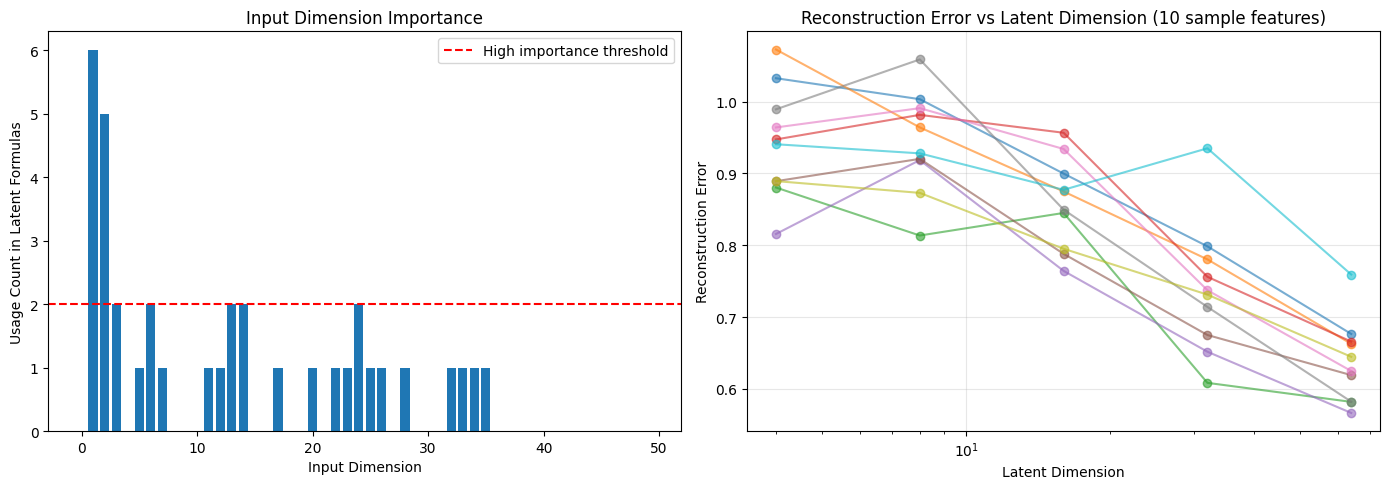

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(min(50, input_dim)), input_importance[:50])
axes[0].set_xlabel('Input Dimension')
axes[0].set_ylabel('Usage Count in Latent Formulas')
axes[0].set_title('Input Dimension Importance')
axes[0].axhline(y=2, color='r', linestyle='--', label='High importance threshold')
axes[0].legend()

sample_features = np.random.choice(input_dim, 10, replace=False)
for feat in sample_features:
    errors = [reconstruction_errors[ld][feat] for ld in latent_dims_to_test]
    axes[1].plot(latent_dims_to_test, errors, marker='o', alpha=0.6)

axes[1].set_xlabel('Latent Dimension')
axes[1].set_ylabel('Reconstruction Error')
axes[1].set_title('Reconstruction Error vs Latent Dimension (10 sample features)')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()